# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 2 - Hierarchical Models in PyMC

**Harvard University**<br>
**Spring 2025**<br>
**Instructors:** Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br>

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import stats
import seaborn as sns

# NEW!
import arviz as az
import pymc as pm

## Hierarchical Models

This notebook is based in large part on [this classic blog post](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/).

>Gelman et al.’s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county’s of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to enter the house through the basement. Moreover, its concentration is thought to differ regionally due to different types of soil.

![radon](images/radon_house.jpg)

In [3]:
df = pd.read_csv('data/radon.csv', index_col=[0])
df['log_radon'] = df['log_radon'].astype('float')
county_names = df.county.unique()
county_idx = df.county_code.values

n_counties = len(df.county.unique())
df.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


Each **row** in the dataframe represents the radon measurements for **one house** in a specific county including whether the measurement was taken in the basement (floor = 0) or the first floor (floor = 1). We are interested in the prediction that radon concentrations are higher in the basement.

To keep things simple let's only use the following three variables: `county`, `log_radon`, and `floor`

In [4]:
# keep only these variables
data = df[['county', 'log_radon', 'floor']]
data.head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


Let's check how many different counties we have. We also notice that each county has a different number of observations. Some have many, some only 1.

In [5]:
# value_counts are sorted in decreasing order by default
data['county'].value_counts().head(5)

county
ST LOUIS      116
HENNEPIN      105
DAKOTA         63
ANOKA          52
WASHINGTON     46
Name: count, dtype: int64

In [6]:
data['county'].value_counts()[-5:]

county
MILLE LACS         2
YELLOW MEDICINE    2
MAHNOMEN           1
WILKIN             1
MURRAY             1
Name: count, dtype: int64

## 1 - Pooling: Same Baysean Linear Regression for All Counties

One approach is to just pool all the data together and fit one big Bayesian regression model to assess the influence of a basement on radon levels across all counties. Our model would be:

\begin{equation}
y_{i} = \beta_0 + \beta_1\times \text{floor}_{i} + \epsilon_i
\end{equation}

If we assume $\epsilon \sim \mathcal{N}(0, 1)$ we can write this as:

\begin{equation}
y_{i} \sim \mathcal{N}(\beta_0 + \beta_1\times \text{floor}_{i}, 1)
\end{equation}

Where $i$ represents the observation (house), and floor is a binary predictor indicating which floor the measurement was taken on. In this pooled approach, we ignore the county feature and treat all observations across counties equally.

#### Build the PyMC Model

[PyMC](https://www.pymc.io/welcome.html) will allow us to both define our probabalistic model and sample from the posterior.

In [7]:
# Defining our PyMC model
with pm.Model() as pooled_model:
    # PRIORS
    # common priors for all counties
    b0 = pm.Normal('b0', mu=0, sigma=100)   
    b1 = pm.Normal('b1', mu=0, sigma=100)

    # single binary predictor
    x = data['floor'].values
    # linear relationship between predictor
    # and the mean of the random variable y (log radon) 
    y_mu = b0 + b1*x
    
    # LIKELIHOOD
    # likelihood after radon observations
    y = pm.Normal('y',
                  mu=y_mu,
                  sigma=1,
                  observed=data['log_radon']) # note here we enter the whole dataset

In [8]:
# displaying the model object shows you the variables and their relationship!
pooled_model

Visualizing the relationship between all the variables in a probabalistic models can be very helpful!

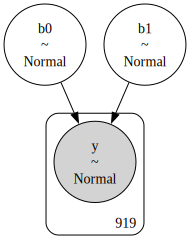

In [9]:
# may require installing python-graphviz
pm.model_to_graphviz(pooled_model)

#### Sample

With our model defined we are ready to sample. The key arguments to `pm.sample` are:
- `draws` - total number of samples we want to keep
- `tune` - number of early 'burn in' samples to throw away
- `chains` - number of parallel markov chains to run
- `target_accept` - you can try and raise this if you get divergence warnings (though it will make your sampling run slower)

`pm.sample` will return a trace object which contains all of out samples for each parameter on each chain.

Note how `pm.sample` is called in a `with` context block. This is necessary to specify which model we are sampling from as the function itself isn't given the model as an argument!

In [10]:
with pooled_model:
    pooled_trace = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9) 
    print(f'DONE')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.


DONE


### Plot the Trace

`pm.plot_trace` trakes the trace object returned by `pm.sample` as an argument. It shows kernel density estimates for all chains for each parameter (left) and the sampling trajectories (i.e., trace) for all chains for each parameter (right).

We are looking for warnings signs that we may not have converged such as the chains not being in agreement or the trajectories not haveing a constant mean and variance.

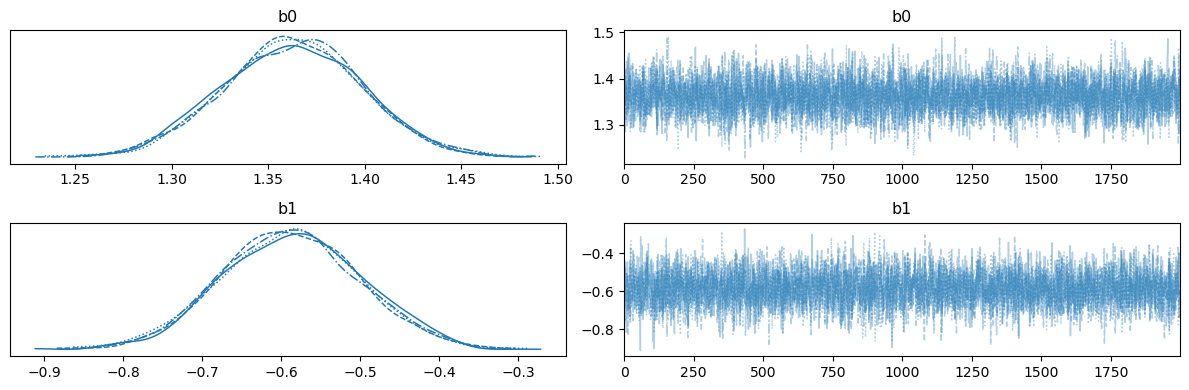

In [11]:
# plot kde for samples and their trace
pm.plot_trace(pooled_trace)
plt.tight_layout();

#### Summary DataFrame

Passing the trace to `pm.summary` gives us a dataframe of statistics about our samples including the mean, standard deviations, bound of the 94% (by default) HDI (highest posterior density interval) as well as the **r_hat** statistics.

High r_hat values are a warning sign that our chains have not converged. As a rule of thumb, r_hat > 1.3 is seen as bad news). The closer to 1 the better.

In [12]:
pm.summary(pooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,1.363,0.036,1.293,1.429,0.001,0.000,4747.0,4669.0,1.0
b1,-0.588,0.089,-0.754,-0.421,0.001,0.001,4646.0,5236.0,1.0


#### Posterior Plots

`pm.plot_posterior` visualizes much of the information in the summary table for us.

We can plot the posters as KDEs...

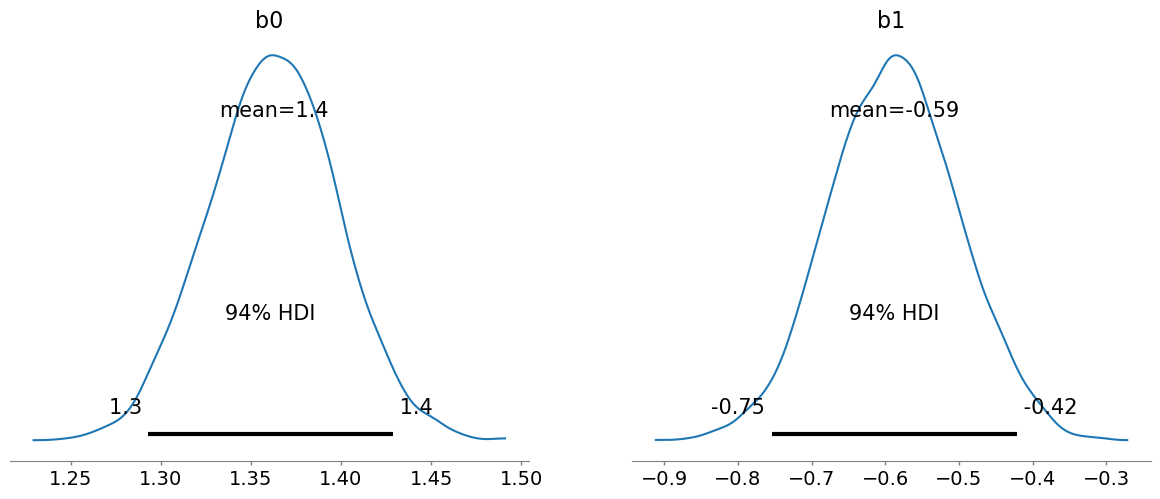

In [13]:
pm.plot_posterior(pooled_trace);

...or as histograms!

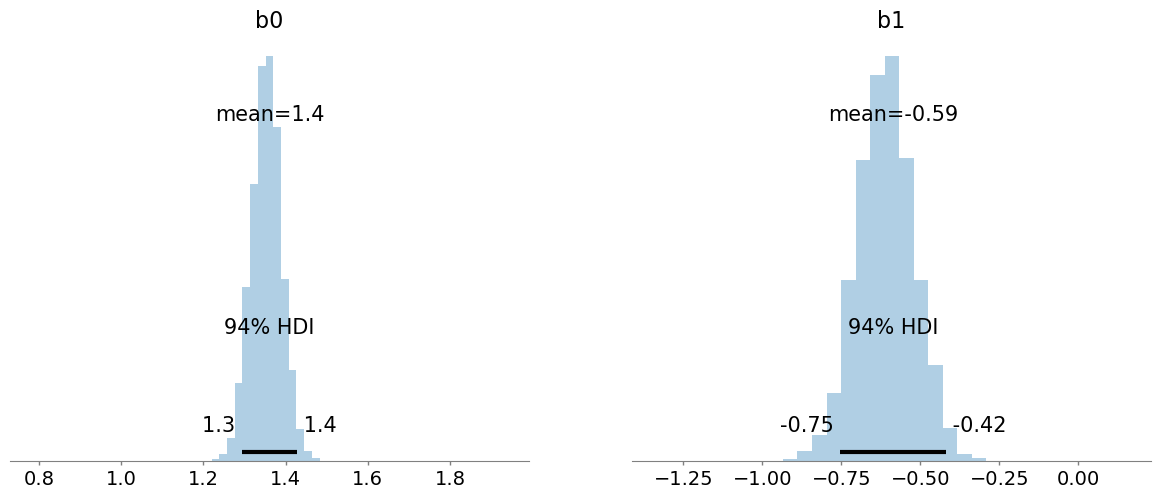

In [14]:
az.plot_posterior(pooled_trace, kind='hist');

There are may options in this and other visualization functions provided to PyMC by the [Arviz](https://www.arviz.org/en/latest/) library. 

#### Pooled Regression Results Across Counties

Remember, with the pooled model we have **only one intercept**, $\beta_0$, and **only one slope**, $\beta_1$ for *all* the counties. Let's plot the regression lines.

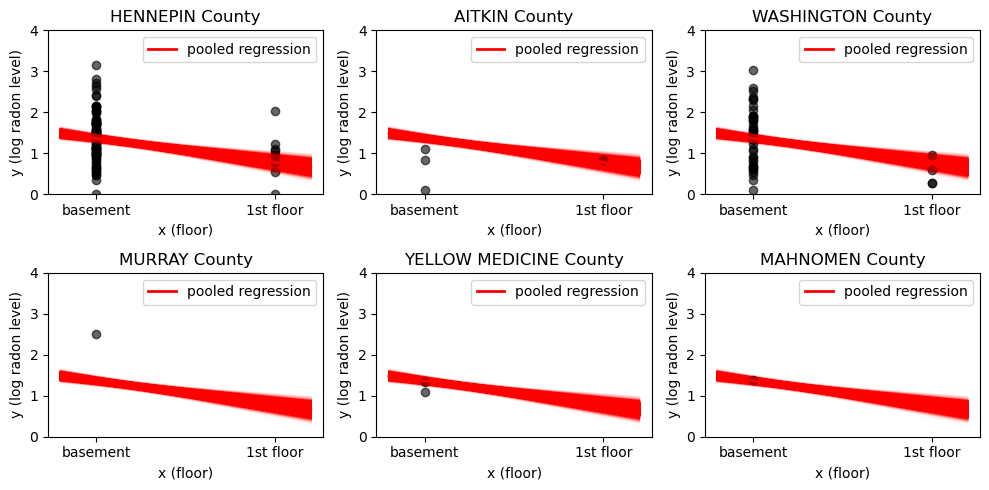

In [15]:
# plot just a subset of the counties
counties = ['HENNEPIN','AITKIN','WASHINGTON', 'MURRAY', 'YELLOW MEDICINE', 'MAHNOMEN']
plt.figure(figsize=(10,5))
rows = 2
gs = gridspec.GridSpec(rows, len(counties)//rows)
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    x_lin = np.linspace(-0.2, 1.2, 100)  # increased points for smoother lines
    
    # Get all samples from the posterior
    b0_samples = pooled_trace.posterior['b0'].stack(samples=("chain", "draw")).values
    b1_samples = pooled_trace.posterior['b1'].stack(samples=("chain", "draw")).values
    
    # Calculate mean for the main line
    b0_mean = b0_samples.mean()
    b1_mean = b1_samples.mean()
    y_hat_mean = b0_mean + b1_mean * x_lin
    
    # Calculate multiple posterior samples
    y_hat_samples = b0_samples[:, None] + b1_samples[:, None] * x_lin[None, :]
    
    subplt = plt.subplot(gs[i])
    subplt.set_ylim(0., 4.)
    
    # Plot the data points
    subplt.scatter(county_data['floor'], county_data['log_radon'], color='black', alpha=0.6)
    
    # Plot multiple posterior samples with low alpha
    subplt.plot(x_lin, y_hat_samples.T, c='r', alpha=0.01)
    
    # Plot the mean line
    subplt.plot(x_lin, y_hat_mean, c='r', label='pooled regression', linewidth=2)
    
    subplt.set_xticks(ticks=[0,1], labels=['basement', '1st floor'])
    subplt.set_xlabel('x (floor)', fontsize=10)
    subplt.set_ylabel('y (log radon level)', fontsize=10)
    subplt.set_title(str(county) + ' County')
    subplt.legend()

plt.tight_layout()

## 2 - Unpooled: A Separate Linear Regression for Each County 

We believe that different counties have different relationships of radon and basements. Our model would be:

$$
\text{log radon}_{i} = \beta_{0,j} + \beta_{1,j}\times floor_{i,j} + \epsilon_i
$$
That is
$$
y_{i} = \beta_{0,j} + \beta_{1,j}x{i,j} + \epsilon_i 
$$

Where $i$ represents the observation (house), $j$ the county, and `floor` is a binary indicator of a house having no basement.

Notice we have separate coefficients for each county. Here we are *not* making the assumption that all these coefficients are coming from the same distribution. They are totally unrelated. One way to think about this approach is that information about other counties have no affect on another's estimated coefficient values.

Fitting an individual Bayesian model (i.e., sampling from the posterior) for every county would take a while. So we will only do a few as an example.

In [16]:
# counties to get their own Bayesian linear regression model
# counties = ['HENNEPIN','AITKIN','WASHINGTON', 'LAKE OF THE WOODS', 'YELLOW MEDICINE', 'ANOKA']
counties = ['HENNEPIN', 'AITKIN', 'WASHINGTON']
unpooled_models = {}
for c in counties:
    with pm.Model() as unpooled_model:
        # common priors for all
        b0 = pm.Normal('b0', mu=0, sigma=100)   
        b1 = pm.Normal('b1', mu=0, sigma=100)

        # relationship between predictor and response mean
        x = data[data['county'] == c]['floor'].values
        y_mu = b0 + b1*x

        # likelihood
        y = pm.Normal(name='y',
                      mu=y_mu,
                      sigma=1,
                      observed=data[data['county'] == c]['log_radon']) # note here we enter the whole dataset
    unpooled_models[c] = unpooled_model

Each model has the same structure as before.

In [17]:
list(unpooled_models.values())[0]

But they each saw different data. Note the number of observed $y$ values listed at the bottom of the graphical model. 

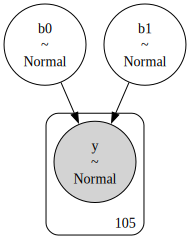

In [18]:
# unpooled model 1
pm.model_to_graphviz(list(unpooled_models.values())[0])

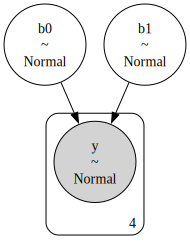

In [19]:
# unpooled model 2
pm.model_to_graphviz(list(unpooled_models.values())[1])

We can sample from each model in a loop and store their trace objects in a dictionary.

In [20]:
traces = {}
for c, m in unpooled_models.items():
    with m:
        traces[c] = pm.sample(draws=200, tune=100, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1]


Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


For each of these models we could again plot the traces to check for convergence...

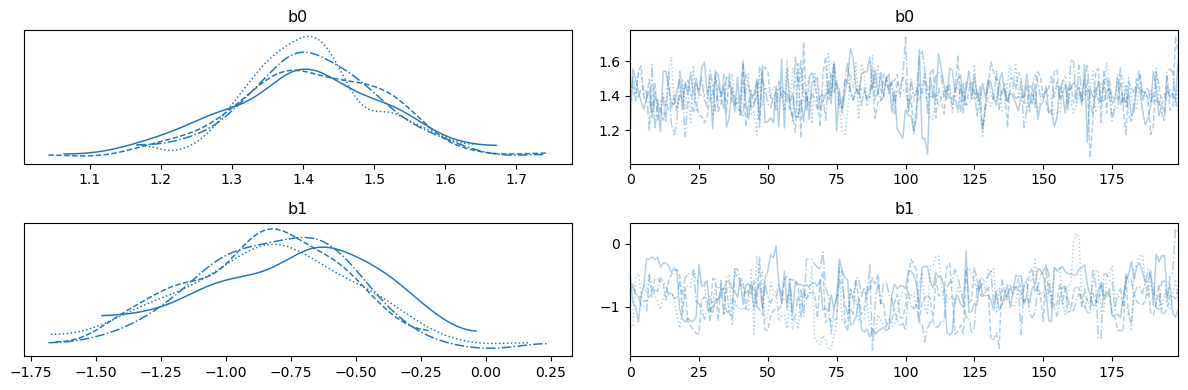

In [21]:
model_to_inspect = 0
pm.plot_trace(list(traces.values())[model_to_inspect])
plt.tight_layout();

...check the r_hat values...

In [22]:
pm.summary(list(traces.values())[model_to_inspect])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,1.409,0.103,1.205,1.598,0.004,0.003,679.0,546.0,1.01
b1,-0.815,0.323,-1.455,-0.304,0.031,0.023,111.0,273.0,1.04


...and visualize the posteriors!

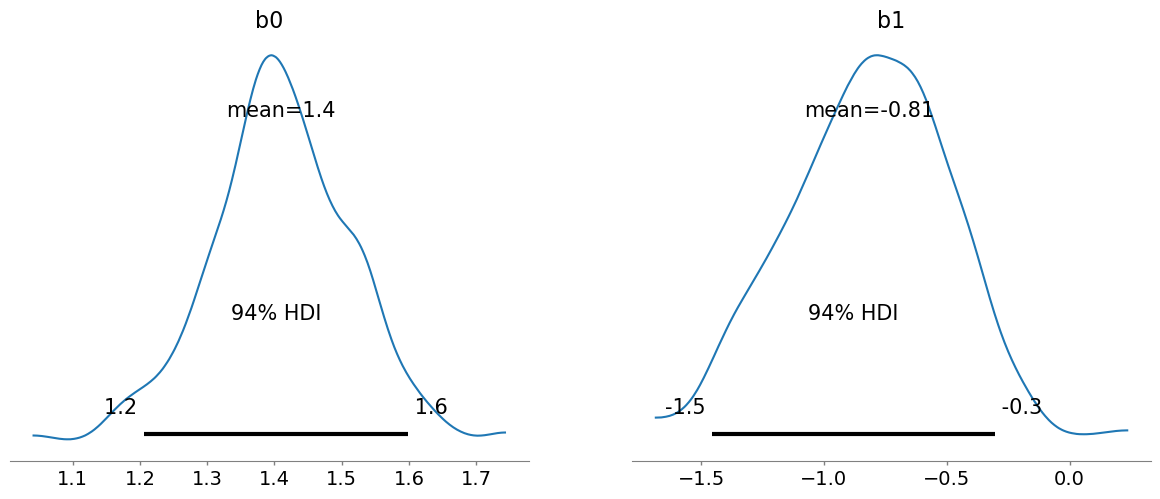

In [23]:
pm.plot_posterior(list(traces.values())[model_to_inspect]);

#### Comparing Pooled to Unpooled

We now have *two* regression lines for each of these counties. One from the pooled model (the same for all counties) and one from the unpooled model that is unique to each county.

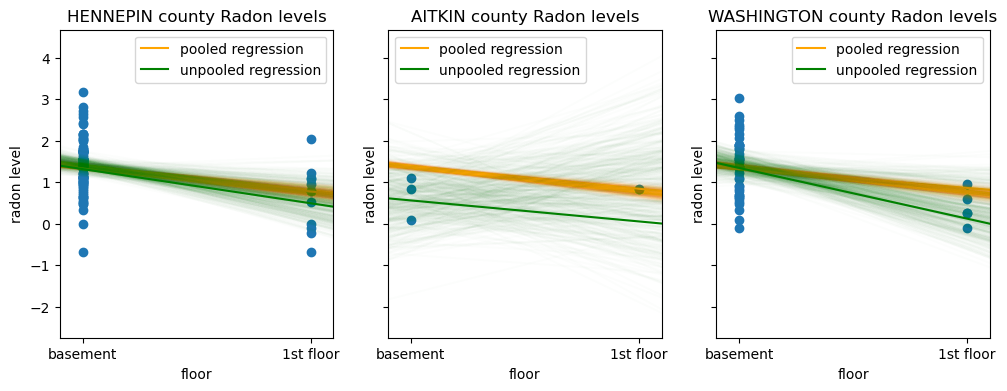

In [24]:
# Plot multiple lines from some subset of the posterior samples as well as the posterior mean
def plot_posterior_lines(trace, color, label, ax, n_lines=500):
    x_lin = np.linspace(-0.2, 1.2)    
    b0s = trace.posterior['b0'].values.flatten()
    b1s = trace.posterior['b1'].values.flatten()
    idx = np.random.choice(len(b0s), size=n_lines, replace=False)
    for b0, b1 in zip(b0s[idx], b1s[idx]):
        ax.plot(x_lin, b0 + b1*x_lin, c=color, alpha=0.01)
    ax.plot(x_lin, b0.mean()+b1.mean()*x_lin, c=color, label=label);
    
fig, axs = plt.subplots(1,len(unpooled_models), figsize=(len(unpooled_models)*4,4), sharey=True)

for ax, county in zip(axs, counties):
    county_data = data.loc[data['county']==county]
    ax.scatter(county_data['floor'], county_data['log_radon'])
    plot_posterior_lines(pooled_trace, color='orange', label='pooled regression', ax=ax)
    plot_posterior_lines(traces[county], color='green', label='unpooled regression', ax=ax)
    ax.set_xlim(-0.1,1.1)
    ax.set_xlabel('floor', fontsize=10)
    ax.set_ylabel('radon level', fontsize=10)
    ax.set_xticks(ticks=[0,1], labels=['basement', '1st floor'])
    ax.set_title(f'{str(county)} county Radon levels')
    ax.legend();

The unpooled model gives us moreflexibility, but there is no shared information! Some counties have very few observations. We can see that this leads to much more uncertainty in the posteriors.

## 3 - Partial pooling: Hierarchical Regression (Varying-Coefficients Model)

We want to allow for differences in coefficients across counties while still believing that these values should be similar. Specifically, we may assume that each $\beta_0$ is drawn from the same distribution. Likewise, we will assume that each $\beta_1$ is drawn from a second distribution.

This amounts to **putting priors on the parameters of our original priors!** We call these *hyperpriors*.

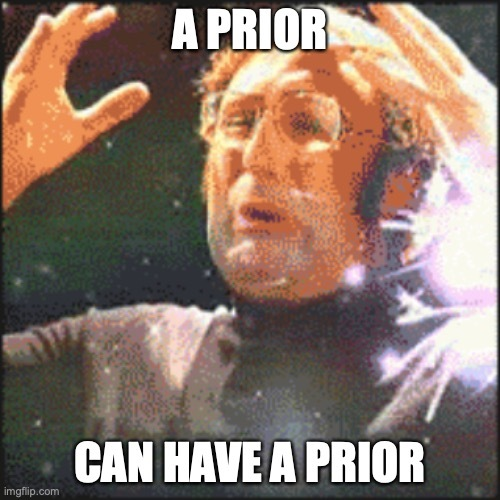

\begin{equation}
y_{i,j} = \beta_{0,j} + \beta_{1,j}x_{i} + \epsilon
\end{equation}   

\begin{equation}
\beta_{0,j} \sim  \mathcal{N}(\mu_{\beta_0},\,\sigma_{\beta_0}^{2})
\end{equation} 
\begin{equation}
\beta_{1,j} \sim \mathcal{N}(\mu_{\beta_1},\,\sigma_{\beta_1}^{2})
\end{equation}

where the common parameters are:
\begin{eqnarray}
\mu_{\beta_0} \sim  \mathcal{N}(0,\,100^2) \\
\sigma_{\beta_0}^2 \sim  |\mathcal{N}(0,\,100^2)| \\
\mu_{\beta_1} \sim  \mathcal{N}(0,\,100^2) \\
\sigma_{\beta_1}^2 \sim  |\mathcal{N}(0,\,100^2)|
\end{eqnarray}

The different counties are effectively sharing information through the common priors. We are thus observing what is known as 'shrinkage'; modeling the groups neither completely independent from each other, nor as a single group, but rather as related.

We saw that some counties had only one sample, so if that house is a really old with old lead pipes, our prediction will be that all houses in this county have radon. On the other extreme, if we have a newer house with no radon then again we will have missleading results. In one case, you will overestimate the bad quality and in the other underestimate it. Under a hierarchical model, the miss-estimation of one group will be offset by the information provided by the other groups. As always gathering more data helps if this is an option.

### Defining the Hierarchical Model 

In [26]:
with pm.Model() as hierarchical_model:
    # your code here
    # Hyperpriors for group nodes
    mu_a = pm.Normal('b0_mu', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('b0_sigma', 5.)
    mu_b = pm.Normal('b1_mu', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('b1_sigma', 5.)

    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('b0', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # beta for each county, distributed around group mean mu_b
    b = pm.Normal('b1', mu=mu_b, sigma=sigma_b, shape=n_counties)

    y_mu = a[county_idx] + b[county_idx]*data['floor'].values

    # Data likelihood
    y = pm.Normal('y',
                  mu=y_mu,
                  sigma=1,
                  observed=data['log_radon'])

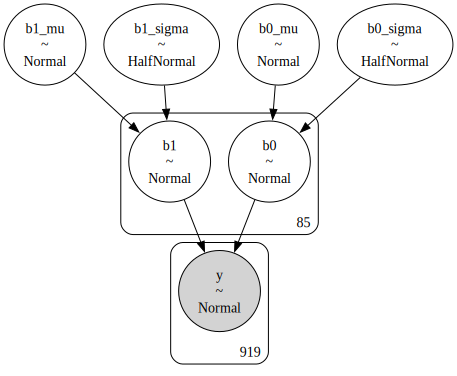

In [27]:
pm.model_to_graphviz(hierarchical_model)

#### Sampling

In [28]:
# Now let's sample from the posterior!
# your code here
with hierarchical_model:
    hierarchical_trace = pm.sample(750, tune=750, target_accept=.95, )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0_mu, b0_sigma, b1_mu, b1_sigma, b0, b1]


Output()

Sampling 4 chains for 750 tune and 750 draw iterations (3_000 + 3_000 draws total) took 12 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Convergence Diagnostics

We can specify which variables to display in the trace plot with the `var_names` argument.

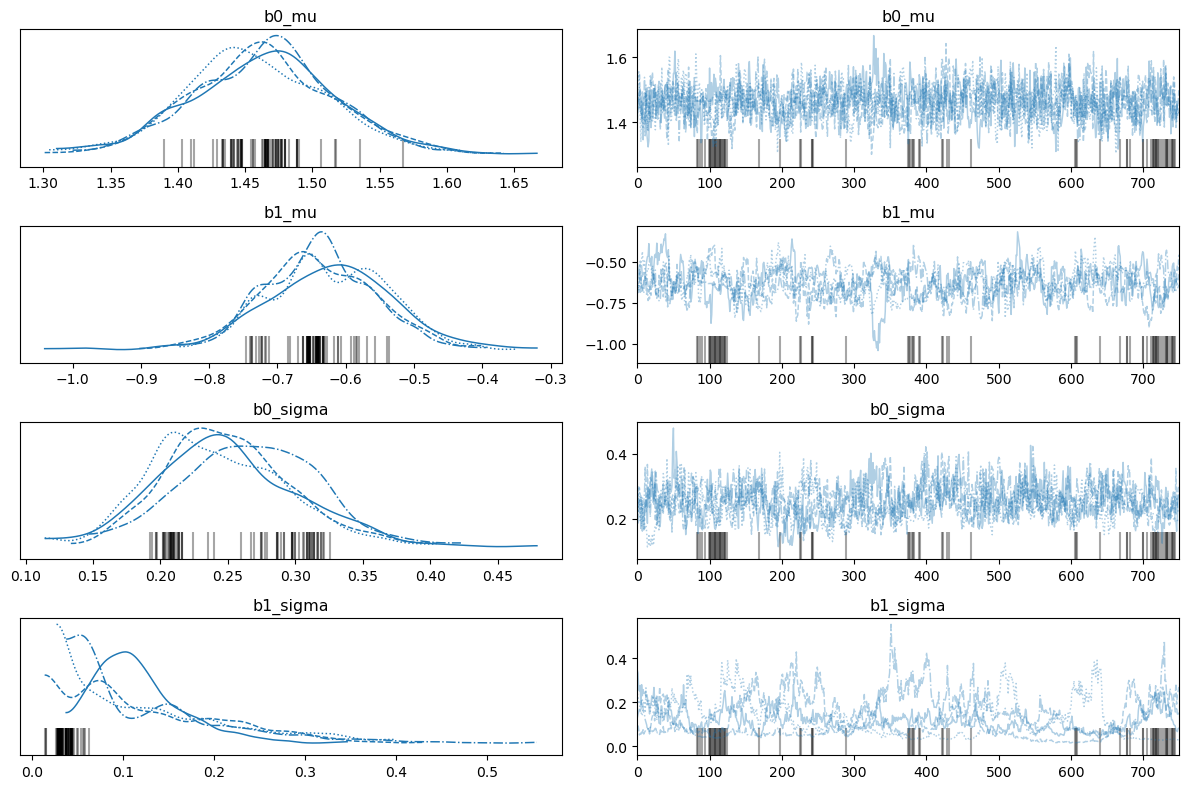

In [29]:
pm.plot_trace(hierarchical_trace, var_names=['b0_mu', 'b1_mu',
                                            'b0_sigma', 'b1_sigma'])
plt.tight_layout();

In [30]:
results = pm.summary(hierarchical_trace) 
results[:10] 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_mu,1.463,0.053,1.363,1.562,0.002,0.002,519.0,1375.0,1.01
b1_mu,-0.632,0.088,-0.781,-0.458,0.007,0.005,174.0,421.0,1.02
b0[0],1.328,0.235,0.884,1.756,0.009,0.006,690.0,1141.0,1.01
b0[1],1.059,0.126,0.827,1.293,0.004,0.003,1229.0,1453.0,1.01
b0[2],1.469,0.245,1.012,1.934,0.007,0.005,1094.0,849.0,1.01
b0[3],1.490,0.211,1.101,1.888,0.005,0.003,2111.0,1826.0,1.00
b0[4],1.451,0.232,1.011,1.898,0.006,0.004,1375.0,1208.0,1.00
b0[5],1.465,0.236,0.996,1.885,0.008,0.005,997.0,1031.0,1.01
b0[6],1.729,0.208,1.379,2.159,0.011,0.008,392.0,281.0,1.01
b0[7],1.564,0.229,1.164,2.046,0.006,0.005,1383.0,964.0,1.01


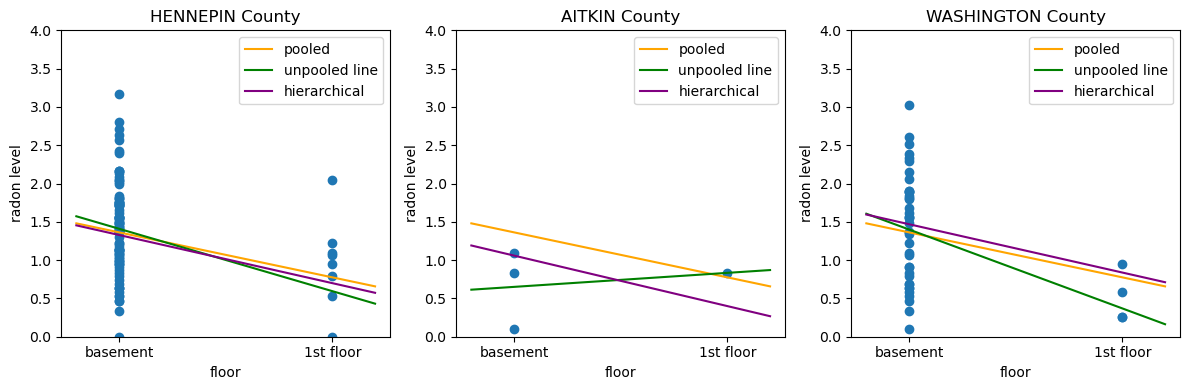

In [31]:
# plot just a subset of the countries
fig, axs = plt.subplots(1,len(unpooled_models), figsize=(len(unpooled_models)*4,4))
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    
    # pooled (single set of coeffs across all counties)
    xx = np.linspace(-0.2, 1.2)    
    y_hat_pooled = pooled_trace.posterior['b0'].mean().values + pooled_trace.posterior['b1'].mean().values*xx
    axs[i].plot(xx, y_hat_pooled, c='orange', label='pooled');
    

    # un-pooled (unique, unrelated coeffs for each per county)
    y_hat_unpooled = traces[county].posterior['b0'].mean().values + traces[county].posterior['b1'].mean().values*x_lin
    axs[i].plot(x_lin, y_hat_unpooled, c='g', label='unpooled line');
    
    # hierarchical (unqiue, but related coeffs for each county)
    y_hat_hier = np.mean(hierarchical_trace.posterior['b0'].values.reshape(-1,data.county.nunique())[:,i]) + \
                      np.mean(hierarchical_trace.posterior['b1'].values.reshape(-1,data.county.nunique())[:,i])*xx 
    axs[i].scatter(county_data['floor'], county_data['log_radon'])
    axs[i].plot(xx, y_hat_hier, c='purple', label='hierarchical');
    
    axs[i].set_xlabel('floor', fontsize=10)
    axs[i].set_ylabel('radon level', fontsize=10)
    axs[i].set_title(str(county) + ' County')
    axs[i].set_ylim(0.,4.)
    axs[i].set_xticks(ticks=[0,1], labels=['basement', '1st floor'])
    axs[i].legend()
    plt.tight_layout();

#### Forest Plots

A forest plot visualizes posterior estimates and their uncertainty, displaying point estimates alongside credible intervals. In hierarchical models, it can illustrate how estimates vary across groups, with shrinkage effects evident when estimates shift toward the overall mean.

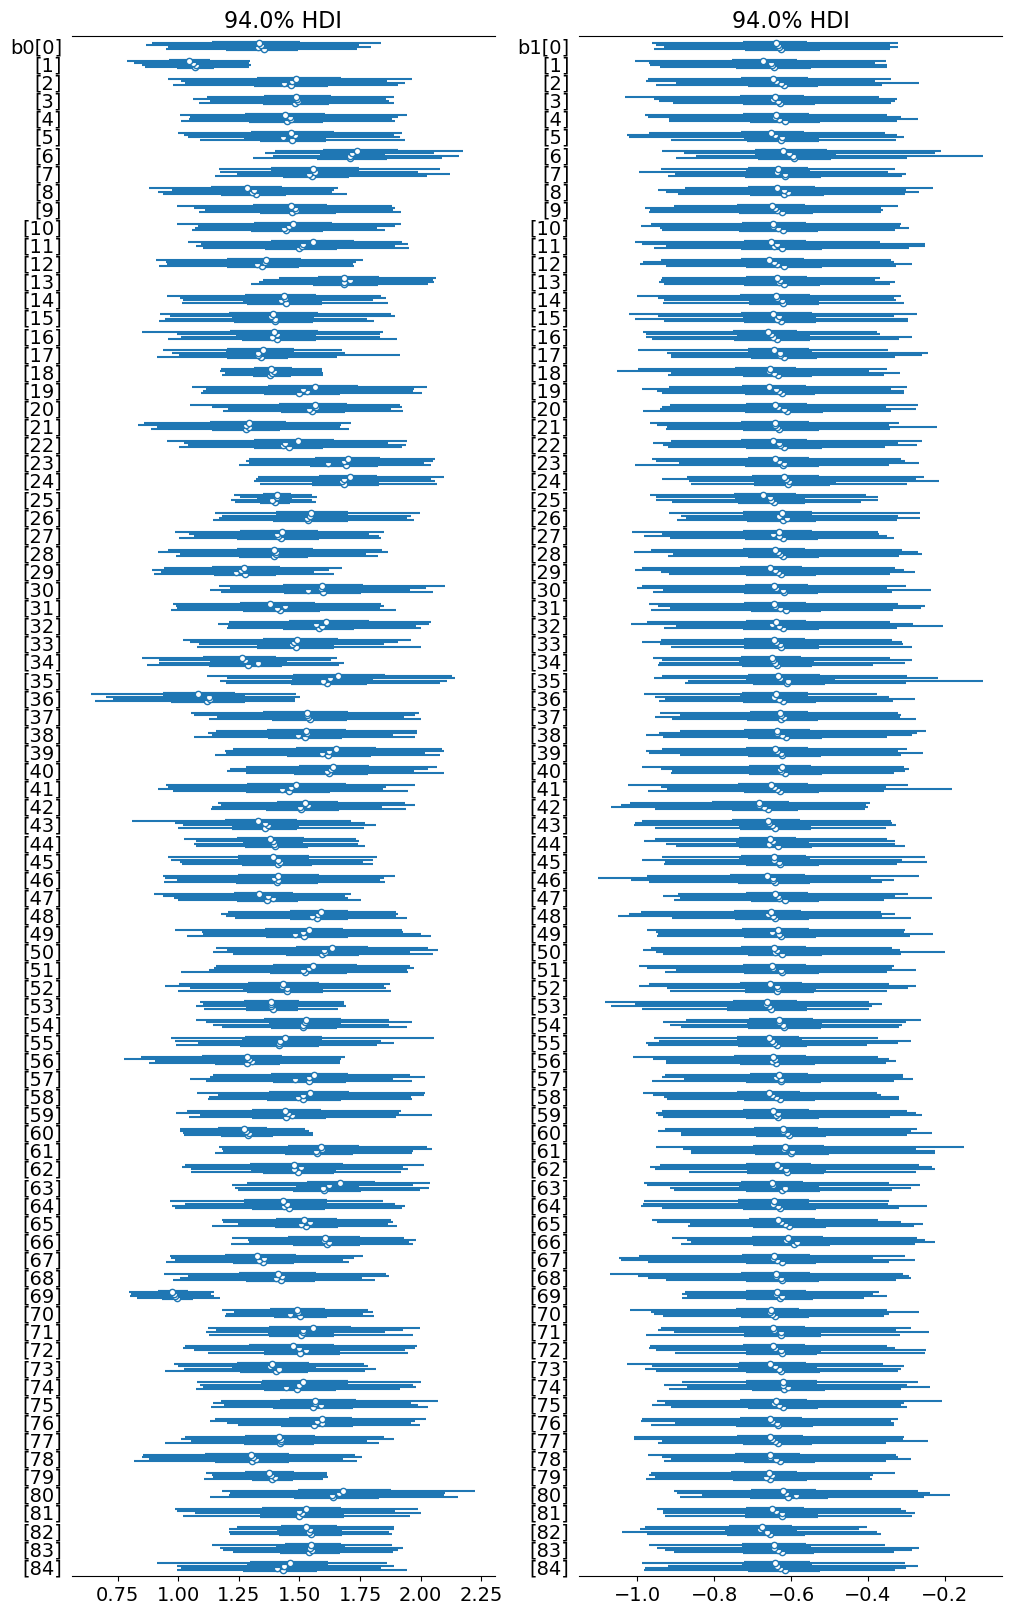

In [32]:
fig, axs = plt.subplots(1,2, figsize=(12, 20))
az.plot_forest(hierarchical_trace, var_names=['b0'], ax=axs[0])
az.plot_forest(hierarchical_trace, var_names=['b1'], ax=axs[1]);

We can also combine the samples from each chain with `combined=True`.

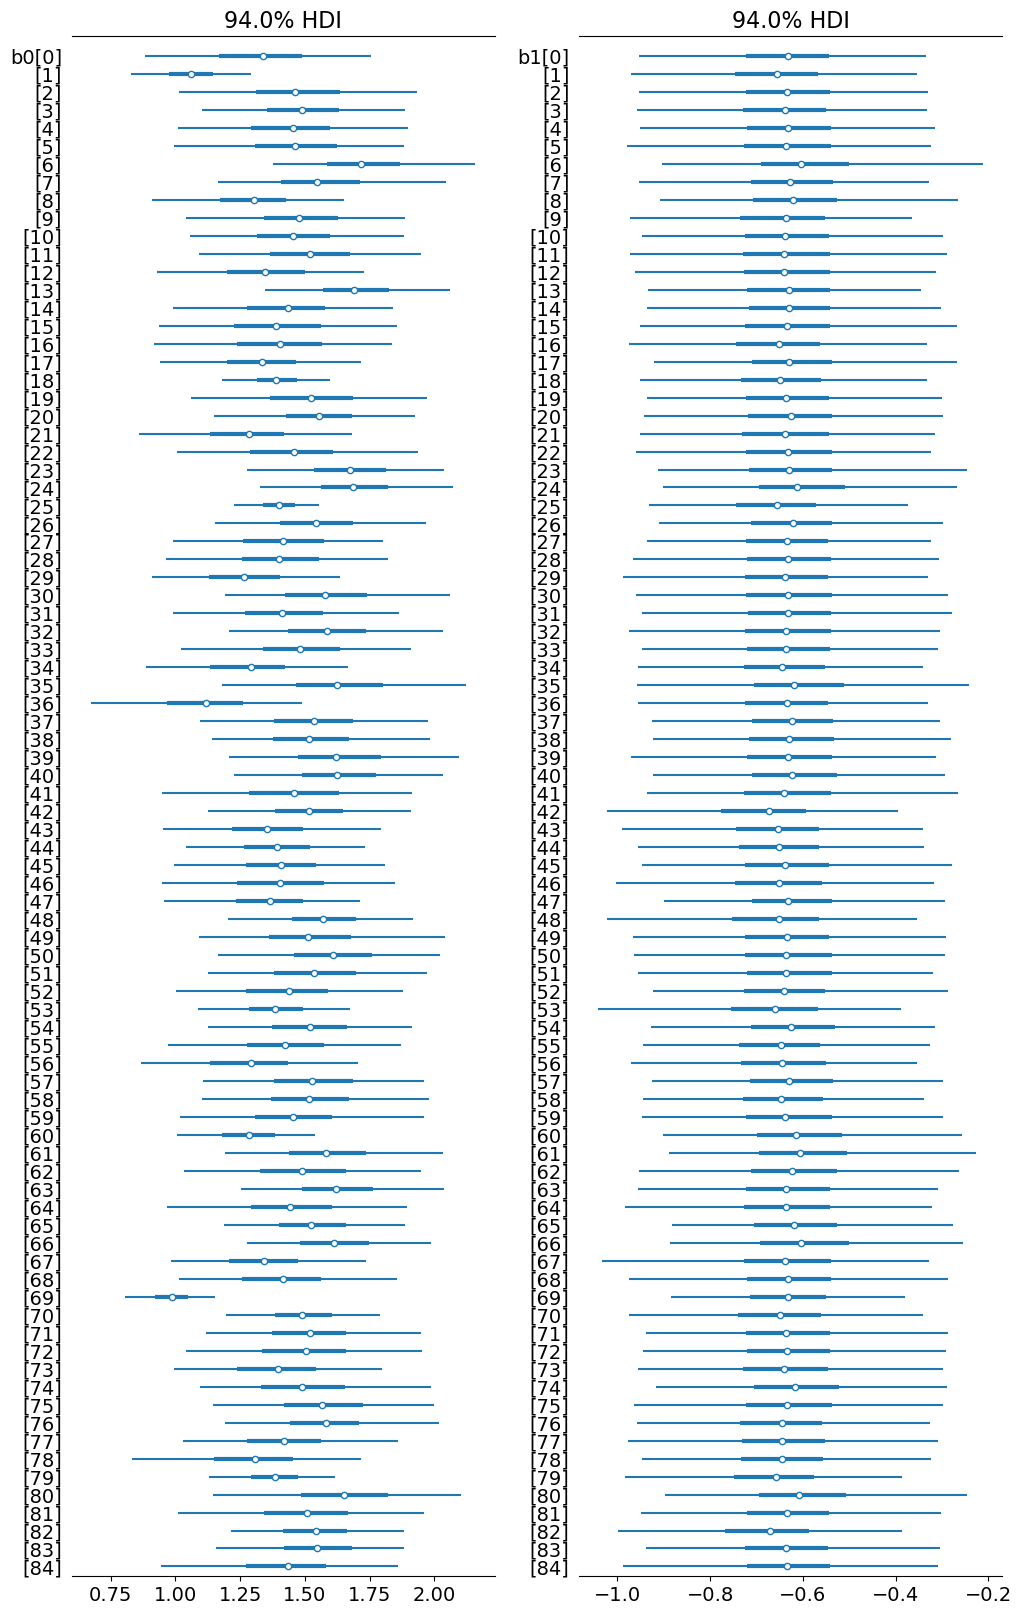

In [33]:
fig, axs = plt.subplots(1,2, figsize=(12, 20))
az.plot_forest(hierarchical_trace, var_names=['b0'], combined=True, ax=axs[0])
az.plot_forest(hierarchical_trace, var_names=['b1'], combined=True, ax=axs[1]);

The forst plots above provide evidence in favor of a varying $\beta_0$ but *not* a varying $\beta_1$.

That is, it appears different counties have different baseline radon levels, but the effect of being in a basement on radon levels is roughly the same across all counties!

We can use this information to make an improved model which is easier to interpret (fewer parameters), fits faster (allowing us to run our chains longer and perhaps achieve better samples), and is less prone to overfitting!

#### Model Only Varying Intercept

In [34]:
with pm.Model() as hierarchical_model2:
    # your code here
    # Hyperpriors for group nodes
    b0_mu = pm.Normal('b0_mu', mu=0., sigma=100)
    b0_sigma = pm.HalfNormal('b0_sigma', 5.)

    # Intercept for each county, distributed around group mean mu_a
    b0 = pm.Normal('b0', mu=b0_mu, sigma=b0_sigma, shape=n_counties)
    
    # same beta1 for all counties (from a normal distribution)
    b1 = pm.Normal('b1', mu=0, sigma=100)

    # relationship of predictor to response mean
    x = data['floor'].values
    y_mu = b0[county_idx] + b1*x

    # likelihood
    y = pm.Normal('y', mu=y_mu,
                  sigma=1, 
                 observed=data['log_radon'])

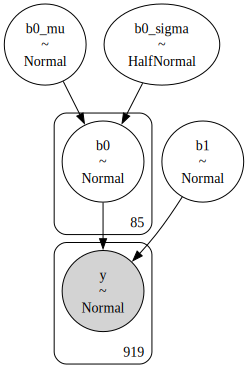

In [35]:
pm.model_to_graphviz(hierarchical_model2)

In [36]:
# Now let's sample from the posterior!
# your code here
with hierarchical_model2:
    hierarchical_trace2 = pm.sample(200, tune=200, target_accept=.9, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0_mu, b0_sigma, b0, b1]


Output()

Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


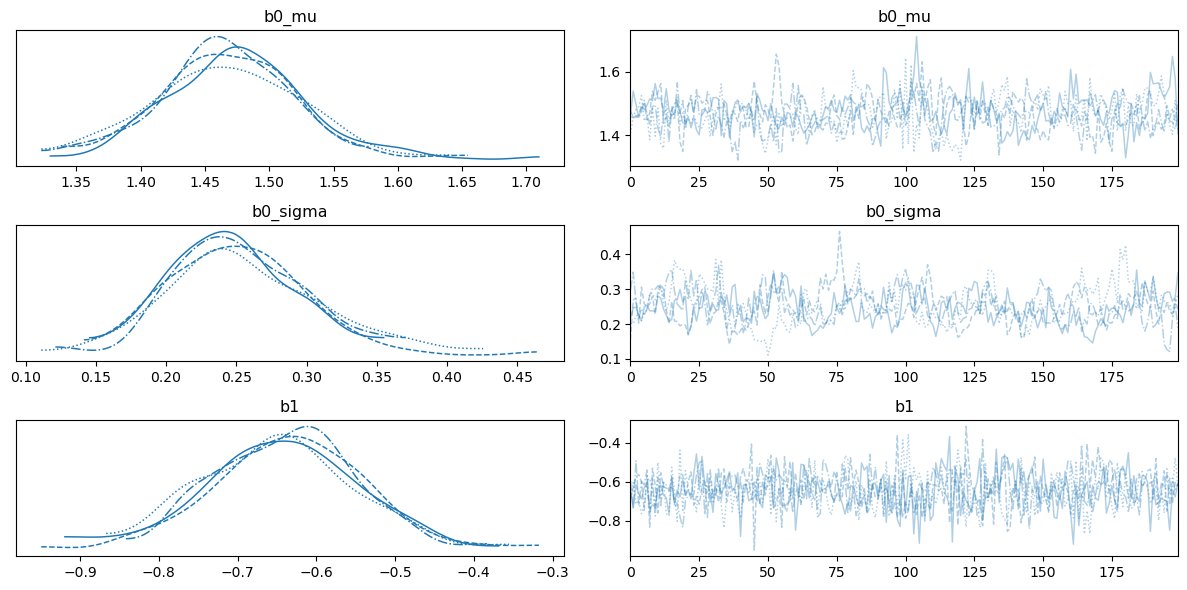

In [37]:
pm.plot_trace(hierarchical_trace2, var_names=['b0_mu','b0_sigma', 'b1'])
plt.tight_layout();

In [38]:
results = pm.summary(hierarchical_trace2) 
results[:10] 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_mu,1.469,0.054,1.366,1.565,0.003,0.002,254.0,394.0,1.01
b0[0],1.348,0.235,0.920,1.783,0.008,0.005,948.0,326.0,1.00
b0[1],1.063,0.128,0.825,1.301,0.006,0.004,535.0,656.0,1.01
b0[2],1.483,0.227,1.034,1.863,0.008,0.005,913.0,551.0,1.00
b0[3],1.497,0.212,1.119,1.895,0.007,0.005,971.0,553.0,1.01
b0[4],1.450,0.226,1.038,1.888,0.007,0.005,978.0,674.0,1.00
b0[5],1.480,0.233,1.071,1.926,0.008,0.006,792.0,662.0,1.00
b0[6],1.716,0.186,1.402,2.101,0.007,0.005,767.0,600.0,1.00
b0[7],1.575,0.246,1.125,2.018,0.009,0.006,859.0,436.0,1.01
b0[8],1.313,0.200,0.923,1.653,0.007,0.005,826.0,655.0,1.00


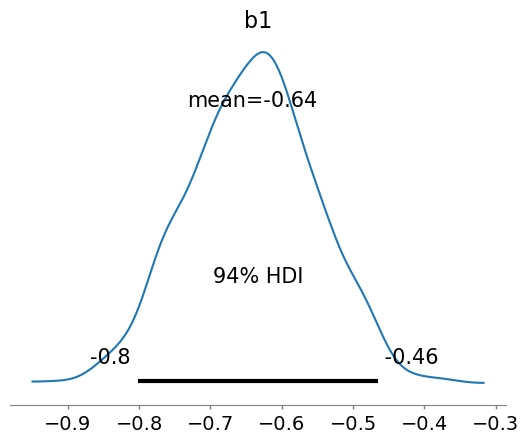

In [39]:
pm.plot_posterior(hierarchical_trace2, var_names=['b1']);

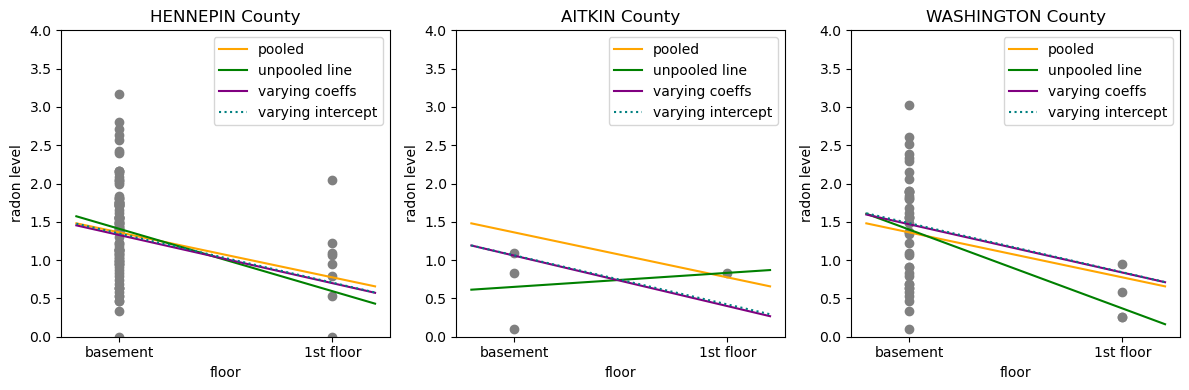

In [40]:
# plot just a subset of the countries
fig, axs = plt.subplots(1,len(unpooled_models), figsize=(4*len(unpooled_models),4))
  
for i, county in enumerate(counties):
    county_data = data.loc[data['county']==county]
    axs[i].scatter(county_data['floor'], county_data['log_radon'], c='gray')
    
    # pooled (single set of coeffs across all counties)
    xx = np.linspace(-0.2, 1.2)    
    y_hat_pooled = pooled_trace.posterior['b0'].mean().values + pooled_trace.posterior['b1'].mean().values*xx
    axs[i].plot(xx, y_hat_pooled, c='orange', label='pooled');
    

    # un-pooled (unique, unrelated coeffs for each per county)
    y_hat_unpooled = traces[county].posterior['b0'].mean().values + traces[county].posterior['b1'].mean().values*x_lin
    axs[i].plot(x_lin, y_hat_unpooled, c='g', label='unpooled line');
    
    # hierarchical (unqiue, but related coeffs for each county)
    y_hat_hier = np.mean(hierarchical_trace.posterior['b0'].values.reshape(-1,data.county.nunique())[:,i]) + \
                      np.mean(hierarchical_trace.posterior['b1'].values.reshape(-1,data.county.nunique())[:,i])*xx 
    axs[i].plot(xx, y_hat_hier, c='purple', label='varying coeffs');
    
    # hierarchical (unqiue, but related coeffs for each county)
    y_hat_hier2 = np.mean(hierarchical_trace2.posterior['b0'].values.reshape(-1,data.county.nunique())[:,i]) + \
                      hierarchical_trace2.posterior['b1'].mean().values*xx 
    axs[i].plot(xx, y_hat_hier2, c='teal', ls=':', label='varying intercept');
    
    axs[i].set_xlabel('floor', fontsize=10)
    axs[i].set_ylabel('radon level', fontsize=10)
    axs[i].set_title(str(county) + ' County')
    axs[i].set_ylim(0.,4.)
    axs[i].set_xticks(ticks=[0,1], labels=['basement', '1st floor'])
    axs[i].legend()
    plt.tight_layout();

**The End** 🌈